In [1]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=3b66c6389a9cc3d156ce471d1e7083229a24d50bd72a3aab8871922af398fb6a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
dataset_root = '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals'
animal_classes = os.listdir(dataset_root)

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
])

In [5]:
class AnimalDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform
        self.data = []
        self.targets = []
        for idx, cls_ in enumerate(classes):
            class_dir = os.path.join(root_dir, cls_)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                self.data.append(image_path)
                self.targets.append(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        target = self.targets[idx]
        return image, target

In [6]:
class_groups = []
group_size = len(animal_classes) // 5
for i in range(0, len(animal_classes), group_size):
    group = animal_classes[i:i+group_size]
    class_groups.append(group)

classes = [cls for group in class_groups for cls in group]

In [7]:
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetModel, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

In [8]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 128 * 56 * 56)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
def visualize_cnn_layers(model, images):
    with torch.no_grad():
        model.eval()
        x = images
        for name, layer in model.named_children():
            if isinstance(layer, nn.Conv2d):
                x = layer(x)
                plt.figure(figsize=(10, 10))
                plt.title(f'Feature Maps - {name}')
                for i in range(x.size(1)):
                    plt.subplot(8, 8, i + 1)
                    plt.imshow(x[0, i].cpu().detach().numpy(), cmap='gray')
                    plt.axis('off')
                plt.show()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
dataset = AnimalDataset(dataset_root, classes, transform=transform)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 234MB/s]


Loaded pretrained weights for efficientnet-b0
Fold [1/3], Epoch [1/5], Train Loss: 1.9686, Val Loss: 1.0792, Train Accuracy: 0.5631, Val Accuracy: 0.7194
Fold [1/3], Epoch [2/5], Train Loss: 0.4766, Val Loss: 1.2124, Train Accuracy: 0.8747, Val Accuracy: 0.7111
Fold [1/3], Epoch [3/5], Train Loss: 0.2467, Val Loss: 0.7094, Train Accuracy: 0.9350, Val Accuracy: 0.8078
Fold [1/3], Epoch [4/5], Train Loss: 0.1750, Val Loss: 0.8052, Train Accuracy: 0.9508, Val Accuracy: 0.7883
Fold [1/3], Epoch [5/5], Train Loss: 0.1301, Val Loss: 0.7557, Train Accuracy: 0.9694, Val Accuracy: 0.8011


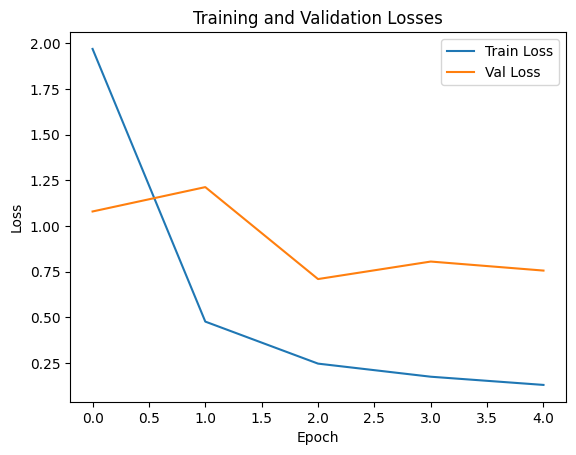

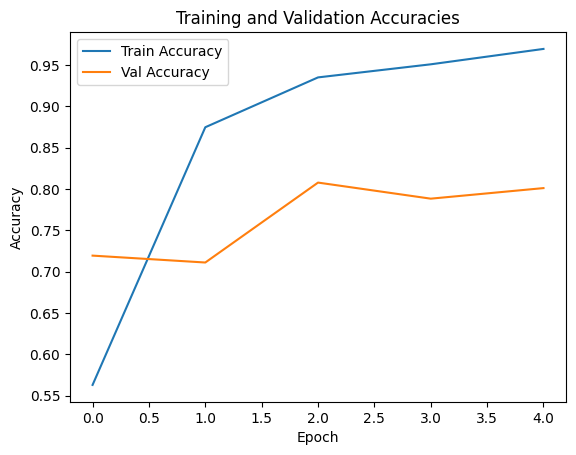

Loaded pretrained weights for efficientnet-b0
Fold [2/3], Epoch [1/5], Train Loss: 1.9828, Val Loss: 1.1024, Train Accuracy: 0.5692, Val Accuracy: 0.6917
Fold [2/3], Epoch [2/5], Train Loss: 0.4886, Val Loss: 0.8337, Train Accuracy: 0.8639, Val Accuracy: 0.7694
Fold [2/3], Epoch [3/5], Train Loss: 0.2359, Val Loss: 0.6797, Train Accuracy: 0.9397, Val Accuracy: 0.8217
Fold [2/3], Epoch [4/5], Train Loss: 0.1705, Val Loss: 0.7536, Train Accuracy: 0.9558, Val Accuracy: 0.8100
Fold [2/3], Epoch [5/5], Train Loss: 0.1446, Val Loss: 0.8531, Train Accuracy: 0.9600, Val Accuracy: 0.8011


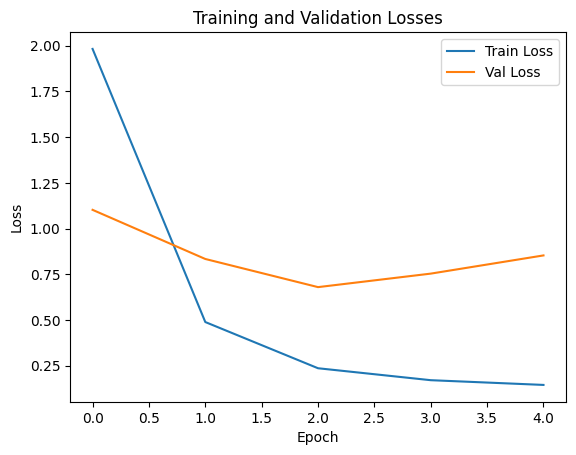

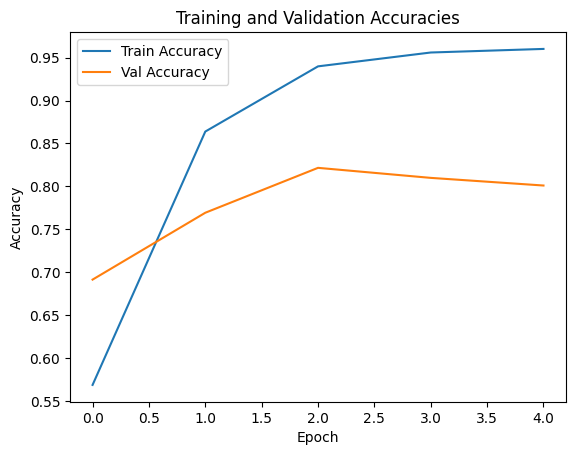

Loaded pretrained weights for efficientnet-b0
Fold [3/3], Epoch [1/5], Train Loss: 1.9566, Val Loss: 0.9983, Train Accuracy: 0.5586, Val Accuracy: 0.7267
Fold [3/3], Epoch [2/5], Train Loss: 0.4753, Val Loss: 0.8752, Train Accuracy: 0.8700, Val Accuracy: 0.7556
Fold [3/3], Epoch [3/5], Train Loss: 0.2208, Val Loss: 0.8013, Train Accuracy: 0.9414, Val Accuracy: 0.8022
Fold [3/3], Epoch [4/5], Train Loss: 0.1270, Val Loss: 0.8097, Train Accuracy: 0.9669, Val Accuracy: 0.7867
Fold [3/3], Epoch [5/5], Train Loss: 0.1413, Val Loss: 0.8386, Train Accuracy: 0.9617, Val Accuracy: 0.7906


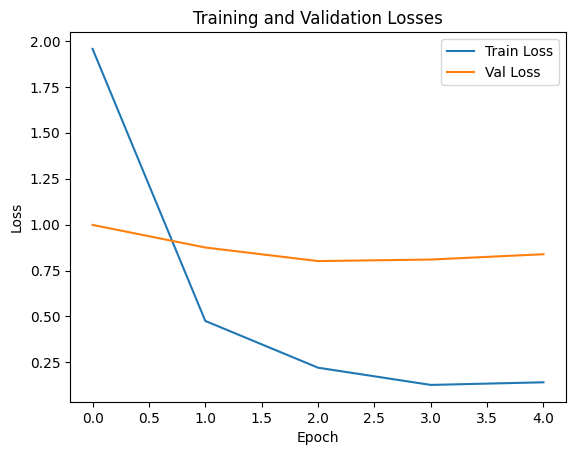

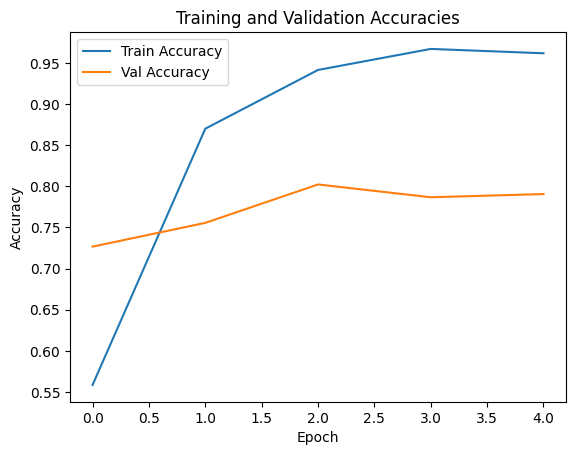

In [12]:
for fold_idx, (train_index, val_index) in enumerate(skf.split(dataset.data, dataset.targets)):
    train_sampler = torch.utils.data.SubsetRandomSampler(train_index)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_index)

    train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

    efficientnet_model = EfficientNetModel(num_classes=len(classes)).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(efficientnet_model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    num_epochs = 5
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        efficientnet_model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = efficientnet_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_index)
        train_losses.append(epoch_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        efficientnet_model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = efficientnet_model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_index)
        val_losses.append(val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f"Fold [{fold_idx+1}/3], Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()
    plt.show()

Fold [1/3], Epoch [1/10], Train Loss: 5.6968, Val Loss: 4.5001, Train Accuracy: 0.0089, Val Accuracy: 0.0111
Fold [1/3], Epoch [2/10], Train Loss: 4.5008, Val Loss: 4.5001, Train Accuracy: 0.0078, Val Accuracy: 0.0111
Fold [1/3], Epoch [3/10], Train Loss: 4.5007, Val Loss: 4.5000, Train Accuracy: 0.0089, Val Accuracy: 0.0111
Fold [1/3], Epoch [4/10], Train Loss: 4.5007, Val Loss: 4.5000, Train Accuracy: 0.0100, Val Accuracy: 0.0111
Fold [1/3], Epoch [5/10], Train Loss: 4.5007, Val Loss: 4.5000, Train Accuracy: 0.0086, Val Accuracy: 0.0111
Fold [1/3], Epoch [6/10], Train Loss: 4.5007, Val Loss: 4.5000, Train Accuracy: 0.0067, Val Accuracy: 0.0111
Fold [1/3], Epoch [7/10], Train Loss: 4.5006, Val Loss: 4.4999, Train Accuracy: 0.0089, Val Accuracy: 0.0111
Fold [1/3], Epoch [8/10], Train Loss: 4.5006, Val Loss: 4.4999, Train Accuracy: 0.0094, Val Accuracy: 0.0111
Fold [1/3], Epoch [9/10], Train Loss: 4.5006, Val Loss: 4.4999, Train Accuracy: 0.0092, Val Accuracy: 0.0111
Fold [1/3], Epoch [

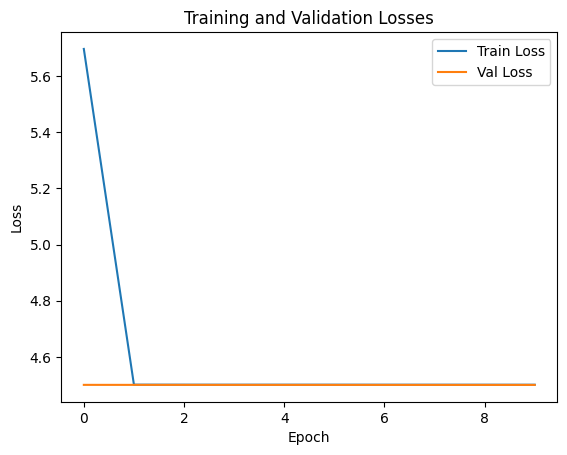

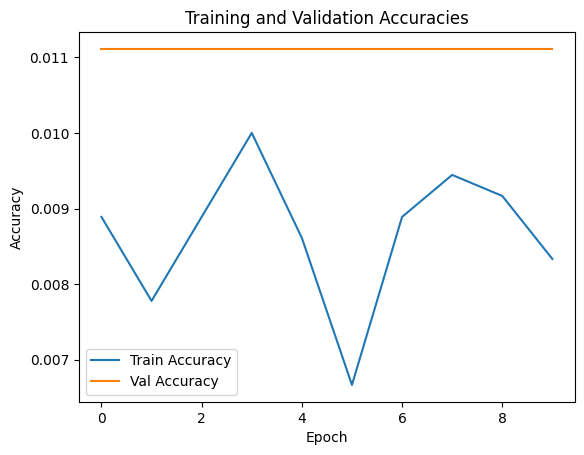

Fold [2/3], Epoch [1/10], Train Loss: 5.6536, Val Loss: 4.5000, Train Accuracy: 0.0097, Val Accuracy: 0.0111
Fold [2/3], Epoch [2/10], Train Loss: 4.5007, Val Loss: 4.5000, Train Accuracy: 0.0092, Val Accuracy: 0.0111
Fold [2/3], Epoch [3/10], Train Loss: 4.5007, Val Loss: 4.5000, Train Accuracy: 0.0078, Val Accuracy: 0.0111
Fold [2/3], Epoch [4/10], Train Loss: 4.5007, Val Loss: 4.5000, Train Accuracy: 0.0075, Val Accuracy: 0.0111
Fold [2/3], Epoch [5/10], Train Loss: 4.5007, Val Loss: 4.4999, Train Accuracy: 0.0067, Val Accuracy: 0.0111
Fold [2/3], Epoch [6/10], Train Loss: 4.5007, Val Loss: 4.4999, Train Accuracy: 0.0067, Val Accuracy: 0.0111
Fold [2/3], Epoch [7/10], Train Loss: 4.5006, Val Loss: 4.4999, Train Accuracy: 0.0086, Val Accuracy: 0.0111
Fold [2/3], Epoch [8/10], Train Loss: 4.5006, Val Loss: 4.4999, Train Accuracy: 0.0111, Val Accuracy: 0.0111
Fold [2/3], Epoch [9/10], Train Loss: 4.5006, Val Loss: 4.4999, Train Accuracy: 0.0078, Val Accuracy: 0.0111
Fold [2/3], Epoch [

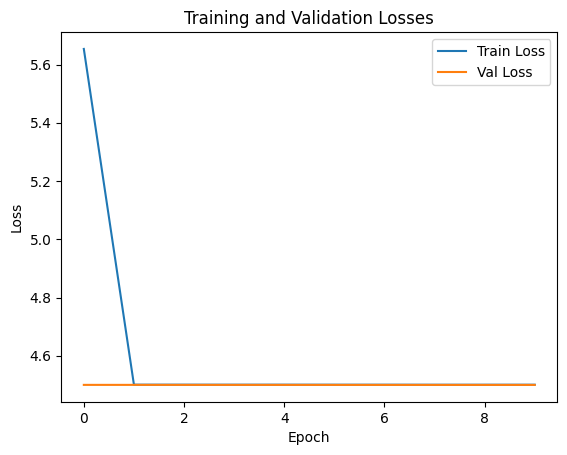

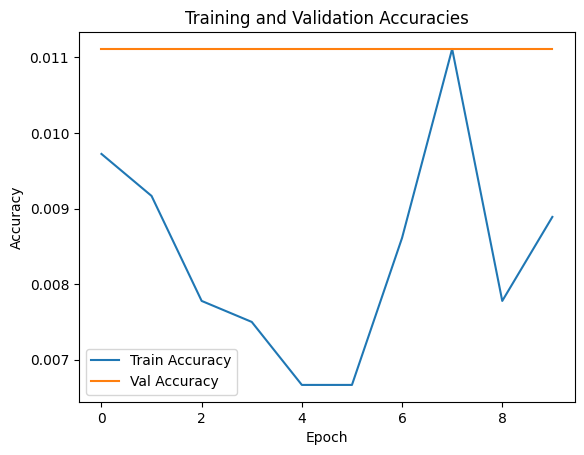

Fold [3/3], Epoch [1/10], Train Loss: 5.7023, Val Loss: 4.5001, Train Accuracy: 0.0089, Val Accuracy: 0.0111
Fold [3/3], Epoch [2/10], Train Loss: 4.5008, Val Loss: 4.5001, Train Accuracy: 0.0094, Val Accuracy: 0.0111
Fold [3/3], Epoch [3/10], Train Loss: 4.5008, Val Loss: 4.5000, Train Accuracy: 0.0061, Val Accuracy: 0.0111
Fold [3/3], Epoch [4/10], Train Loss: 4.5007, Val Loss: 4.5000, Train Accuracy: 0.0086, Val Accuracy: 0.0111
Fold [3/3], Epoch [5/10], Train Loss: 4.5007, Val Loss: 4.5000, Train Accuracy: 0.0089, Val Accuracy: 0.0111
Fold [3/3], Epoch [6/10], Train Loss: 4.5007, Val Loss: 4.5000, Train Accuracy: 0.0089, Val Accuracy: 0.0111
Fold [3/3], Epoch [7/10], Train Loss: 4.5006, Val Loss: 4.4999, Train Accuracy: 0.0078, Val Accuracy: 0.0111
Fold [3/3], Epoch [8/10], Train Loss: 4.5006, Val Loss: 4.4999, Train Accuracy: 0.0081, Val Accuracy: 0.0111
Fold [3/3], Epoch [9/10], Train Loss: 4.5006, Val Loss: 4.4999, Train Accuracy: 0.0111, Val Accuracy: 0.0111
Fold [3/3], Epoch [

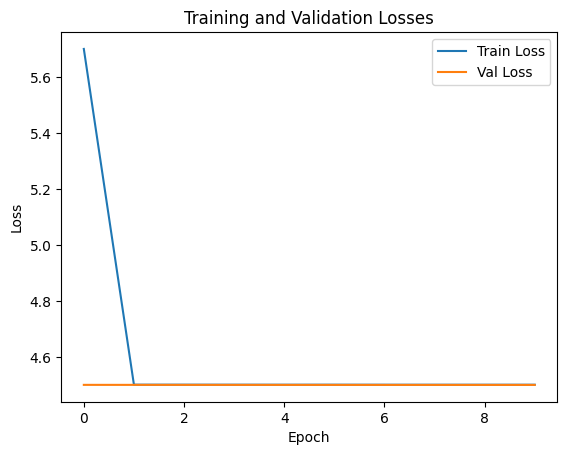

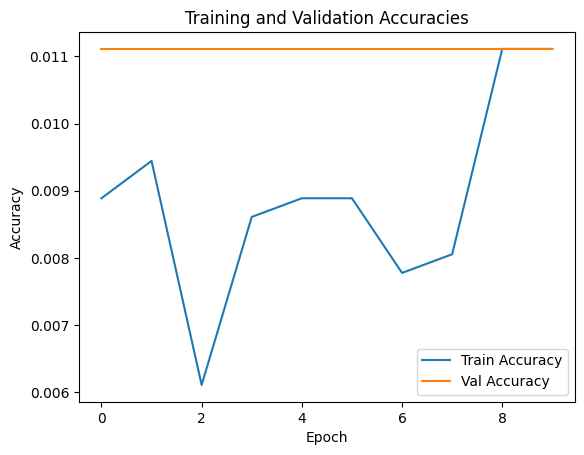

In [13]:
for fold_idx, (train_index, val_index) in enumerate(skf.split(dataset.data, dataset.targets)):
    train_sampler = torch.utils.data.SubsetRandomSampler(train_index)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_index)

    train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

    efficientnet_model = CustomCNN(num_classes=len(classes)).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(efficientnet_model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    num_epochs = 10
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        efficientnet_model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = efficientnet_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_index)
        train_losses.append(epoch_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        efficientnet_model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = efficientnet_model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_index)
        val_losses.append(val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f"Fold [{fold_idx+1}/3], Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()
    plt.show()